In [1]:
!nvidia-smi

Sun Aug 24 17:44:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Import And Split**

In [2]:
# ============================================================
# 0. Setup
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset paths
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_baseline")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# Custom folder for all outputs
OUTPUT_FOLDER = Path("/kaggle/working/base_yolov10")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. VOC → YOLO conversion + train/val/test split
# ============================================================
def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    all_pairs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))

    print(f"Found {len(all_pairs)} annotated images total.")
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "val":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

# Create data.yaml for YOLOv10
DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready:", DATA)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

**Train Yolo Baseline**

In [3]:
# ============================================================
# 2. Train YOLOv10 baseline (outputs in custom folder)
# ============================================================
model = YOLO("yolov10s.pt")  # baseline small version
model.train(
    data=str(DATA),
    epochs=50,        # increase if resources allow
    imgsz=640,
    batch=16,
    workers=2,
    project=str(OUTPUT_FOLDER),  # <- save all outputs here
    name="train"                 # <- folder name inside project
)


Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_baseline/data_traffic.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1425.0±821.7 MB/s, size: 72.2 KB)


train: Scanning /kaggle/working/traffic_baseline/yolo_split/train/labels... 16574 images, 40 backgrounds, 0 corrupt: 100%|██████████| 16574/16574 [00:11<00:00, 1432.94it/s]

train: /kaggle/working/traffic_baseline/yolo_split/train/images/frame195_jpg.rf.46fd02322bca0e4c4437d57807d7a178.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/traffic_baseline/yolo_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 462.4±309.1 MB/s, size: 67.0 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/val/labels... 4735 images, 11 backgrounds, 0 corrupt: 100%|██████████| 4735/4735 [00:03<00:00, 1341.22it/s]

val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame0_jpg.rf.e1bc04102d10d13d3e4801450a664640.jpg: 2 duplicate labels removed
val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame1_jpg.rf.af73293c83d849389bfeacd60c71cd38.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/traffic_baseline/yolo_split/val/labels.cache
Plotting labels to /kaggle/working/base_yolov10/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/base_yolov10/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.03G      2.956      2.809      2.216        212        640: 100%|██████████| 1036/1036 [06:34<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:39<00:00,  3.78it/s]


                   all       4735      46319       0.54      0.537      0.578      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.63G      2.727      1.965      2.127        235        640: 100%|██████████| 1036/1036 [06:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]


                   all       4735      46319      0.584      0.577      0.589      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.66G      2.755      1.971      2.156        192        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]


                   all       4735      46319       0.51      0.586      0.578      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.69G      2.749      1.962      2.167        212        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]


                   all       4735      46319      0.595      0.562      0.596      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.72G      2.677      1.866      2.145        223        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]


                   all       4735      46319      0.557      0.612      0.615      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.75G      2.617      1.805      2.126        296        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]


                   all       4735      46319      0.562      0.585      0.623      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.79G      2.583      1.755       2.11        288        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]


                   all       4735      46319      0.587      0.641      0.648      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.81G      2.552      1.717      2.099        274        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]


                   all       4735      46319      0.717      0.583       0.64      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.85G      2.527      1.684      2.091        206        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]


                   all       4735      46319      0.589      0.642      0.658      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.88G      2.505      1.666      2.082        232        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]


                   all       4735      46319      0.571      0.658      0.656      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.91G      2.479       1.64       2.07        268        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]


                   all       4735      46319      0.566      0.675      0.661      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.94G      2.458      1.611      2.066        232        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]


                   all       4735      46319      0.586      0.652       0.67      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.97G      2.444      1.604      2.054        155        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]


                   all       4735      46319      0.611      0.659       0.68      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         6G      2.427      1.589      2.051        268        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]


                   all       4735      46319      0.606      0.658      0.672      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.03G      2.418      1.572      2.044        239        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]


                   all       4735      46319      0.596      0.657      0.666      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.06G      2.403      1.558      2.043        243        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.88it/s]


                   all       4735      46319      0.601      0.673      0.687      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.09G      2.386      1.541      2.033        174        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]


                   all       4735      46319      0.618       0.68      0.692      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.12G      2.374      1.528      2.034        243        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]


                   all       4735      46319      0.619       0.68      0.693      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.15G      2.363      1.515      2.027        250        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]


                   all       4735      46319      0.614      0.688      0.698      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.18G      2.351      1.503      2.019        176        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]

                   all       4735      46319       0.67      0.642      0.702      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.21G      2.341      1.494      2.018        179        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]


                   all       4735      46319      0.617      0.688      0.701      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.24G       2.33      1.483      2.013        176        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]

                   all       4735      46319      0.641      0.685      0.702      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.27G      2.318      1.473      2.008        191        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]

                   all       4735      46319      0.643      0.667      0.708       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       6.3G      2.306      1.461      2.005        242        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:40<00:00,  3.70it/s]


                   all       4735      46319       0.65      0.678      0.716      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.33G      2.297      1.454      1.997        135        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.625      0.695      0.712      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.36G      2.284      1.436      1.995        214        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.645      0.683      0.712      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.39G      2.278      1.425       1.99        213        640: 100%|██████████| 1036/1036 [06:31<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

                   all       4735      46319      0.649      0.682      0.718      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.42G      2.266      1.421      1.993        190        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]

                   all       4735      46319      0.662      0.674      0.716      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.45G      2.245      1.403      1.978        292        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.636      0.703      0.719       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.48G      2.242      1.394      1.977        211        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

                   all       4735      46319      0.661      0.685      0.717      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.51G      2.226      1.385      1.975        221        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]

                   all       4735      46319      0.662      0.676      0.722      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.54G      2.219      1.373      1.973        266        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]

                   all       4735      46319      0.645      0.698      0.723      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.57G      2.209      1.366      1.968        191        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]

                   all       4735      46319      0.646      0.702      0.722      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       6.6G      2.202      1.358      1.965        233        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

                   all       4735      46319       0.65      0.698      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.63G      2.191      1.348      1.958        131        640: 100%|██████████| 1036/1036 [06:33<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]

                   all       4735      46319      0.648      0.699      0.723      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.67G      2.181      1.339      1.955        257        640: 100%|██████████| 1036/1036 [06:34<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]

                   all       4735      46319       0.66      0.695      0.727      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       6.7G      2.168      1.326      1.948        218        640: 100%|██████████| 1036/1036 [06:33<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]

                   all       4735      46319      0.666      0.705      0.726        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.73G      2.152      1.317      1.947        194        640: 100%|██████████| 1036/1036 [06:33<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.651      0.712      0.726      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.76G      2.155      1.311      1.946        183        640: 100%|██████████| 1036/1036 [06:33<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.643      0.715      0.725      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.79G      2.137      1.293       1.94        216        640: 100%|██████████| 1036/1036 [06:32<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.659      0.693      0.727      0.505


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.82G      2.074      1.193      1.936        121        640: 100%|██████████| 1036/1036 [06:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]

                   all       4735      46319      0.642       0.72      0.726      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.85G      2.048       1.17       1.93        121        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]

                   all       4735      46319      0.643      0.715      0.726      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.88G      2.028      1.155       1.92        144        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]

                   all       4735      46319      0.646      0.718      0.726      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.91G      2.016      1.143      1.917        108        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]

                   all       4735      46319      0.664      0.701      0.729      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.94G          2       1.13      1.913        130        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

                   all       4735      46319      0.677      0.694      0.728      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.97G      1.981      1.113      1.901        141        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]

                   all       4735      46319      0.666      0.702      0.728      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         7G      1.968      1.098      1.896        120        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]

                   all       4735      46319      0.661       0.71      0.729      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.03G      1.953      1.086       1.89        147        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

                   all       4735      46319      0.658      0.713      0.728      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.06G      1.936      1.074      1.887        130        640: 100%|██████████| 1036/1036 [06:21<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.669      0.708      0.728      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.09G      1.927      1.062      1.884        133        640: 100%|██████████| 1036/1036 [06:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:38<00:00,  3.85it/s]

                   all       4735      46319      0.671      0.705      0.727      0.504



50 epochs completed in 5.964 hours.
Optimizer stripped from /kaggle/working/base_yolov10/train/weights/last.pt, 16.5MB
Optimizer stripped from /kaggle/working/base_yolov10/train/weights/best.pt, 16.5MB

Validating /kaggle/working/base_yolov10/train/weights/best.pt...
Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,221,483 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:35<00:00,  4.19it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46319      0.662      0.702      0.729      0.506
              Rickshaw       3906      11944      0.769      0.862      0.901      0.632
                   Bus       3865      10420      0.775      0.849      0.889      0.653
                 Truck        225        237      0.439      0.477      0.465      0.359
                  Bike       2118       3183      0.729      0.801      0.836      0.512
                People       2883       7560      0.744      0.803      0.857      0.556
                   Car       4267      12833       0.82      0.891      0.934      0.706
                 Cycle        138        142       0.36       0.23      0.223      0.123
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/base_yolov10/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78b6aa3e4ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

**Evaluate**

In [4]:
# ============================================================
# 3. Evaluate on test set + generate plots (outputs in same folder)
# ============================================================
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,
    project=str(OUTPUT_FOLDER),  # <- same output folder
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)

Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,221,483 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1449.6±512.1 MB/s, size: 72.8 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels... 2369 images, 4 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:01<00:00, 1438.35it/s]

val: New cache created: /kaggle/working/traffic_baseline/yolo_split/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:26<00:00,  5.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      22805      0.702      0.669      0.742      0.517
              Rickshaw       1940       6031      0.809      0.828        0.9      0.627
                   Bus       1958       5098      0.807      0.812       0.89      0.651
                 Truck        112        119      0.433      0.454      0.464      0.382
                  Bike       1016       1526      0.774      0.763      0.838      0.516
                People       1423       3695      0.785      0.761       0.86      0.551
                   Car       2140       6281      0.845      0.858       0.93      0.702
                 Cycle         53         55      0.465      0.206      0.311      0.188
Speed: 0.3ms preprocess, 8.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/base_yolov10/val
mAP@0.5     : 0.7417117737423935
mAP@[.5:.95]: 0.5166084450976283
Precision   : 0.7024966222773054
Recall      : 0.6687472696028097


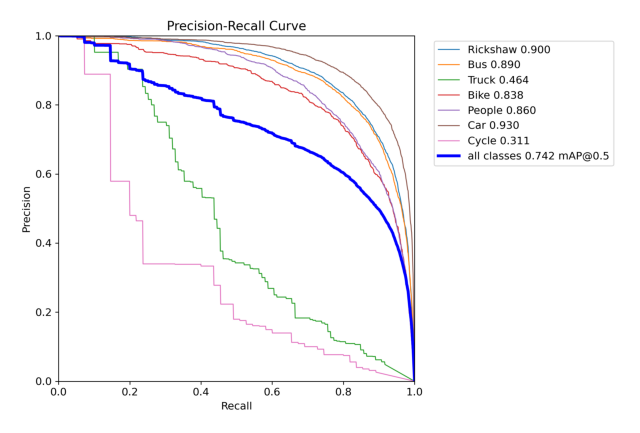

In [5]:
# ============================================================
# 4. Visualize PR curve from custom folder
# ============================================================
pr_curve_file = list((OUTPUT_FOLDER/"val").glob("*PR_curve*.png"))[0]
img = mpimg.imread(pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# ============================================================
# 5. Model speed / latency (FPS)
# ============================================================
results = model(str(SPLIT/"test/images"), device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

FPS ≈ 19.981314274685


In [7]:
#best model

from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Path to your trained model
best_model_path = Path("/kaggle/working/base_yolov10/train/weights/best.pt")

# Load the trained YOLOv10 model
model = YOLO(str(best_model_path))

# ============================================================
# Evaluate on test set
# ============================================================
DATA = "/kaggle/working/traffic_baseline/data_traffic.yaml"

metrics = model.val(
    data=DATA,
    split="test",
    plots=True,           # generates PR curve, confusion matrix, etc.
    project="/kaggle/working/base_yolov10",
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)


# ============================================================
# Inference on test images + FPS
# ============================================================
results = model("/kaggle/working/traffic_baseline/yolo_split/test/images", device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)

# ============================================================
# Model complexity (params / GMACs)
# ============================================================
model.info(detailed=True)


Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,221,483 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1288.4±299.1 MB/s, size: 69.3 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels.cache... 2369 images, 4 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:25<00:00,  5.75it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      22805      0.702      0.669      0.742      0.517
              Rickshaw       1940       6031      0.809      0.828        0.9      0.627
                   Bus       1958       5098      0.807      0.812       0.89      0.651
                 Truck        112        119      0.433      0.454      0.464      0.382
                  Bike       1016       1526      0.774      0.763      0.838      0.516
                People       1423       3695      0.785      0.761       0.86      0.551
                   Car       2140       6281      0.845      0.858       0.93      0.702
                 Cycle         53         55      0.465      0.206      0.311      0.188
Speed: 0.3ms preprocess, 7.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/base_yolov10/val2
mAP@0.5     : 0.7417117737423935
mAP@[.5:.95]: 0.5166084450976283
Precision   : 0.7024966222773054
Recall      : 0.6687472696028097
WARNING ⚠️ 
inference r

(106, 7221483, 0, 21.4319616)